In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import scConnect as cn
import numpy as np
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.2 scipy==1.4.1 pandas==0.23.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


# Human melanoma tumor Tirosh et al

In [2]:
df = pd.read_csv("../data/GSE72056_melanoma_single_cell_revised_v2.txt.gz", sep="\t", index_col=0)

In [3]:
x = df[3:]
meta = df[:3]
print(x.values.shape)
print(meta.shape)

(23686, 4645)
(3, 4645)


In [4]:
adata_h = sc.AnnData(X=x.T.values, var=x.index, obs=x.columns)

In [5]:
adata_h.obs = meta.T

In [6]:
adata_h.var_names = x.index

In [7]:
adata_h.var_names_make_unique()
adata_h.obs_names_make_unique()

In [8]:
adata_h.X # reads in log2(TPM/10+1)
(np.exp2(adata_h.X)-1)*10

array([[   0.      , 5941.875   ,    0.      , ...,    0.      ,
          53.37    ,    0.      ],
       [   0.      , 3308.7598  ,    0.      , ...,    0.      ,
        1261.2463  ,    0.      ],
       [   0.      , 6350.515   ,   33.659637, ...,  136.99551 ,
          20.580244,    0.      ],
       ...,
       [   0.      , 1357.882   ,    0.      , ...,    0.      ,
          28.94667 ,    0.      ],
       [   0.      ,  149.66765 ,    0.      , ...,    0.      ,
        1452.0007  ,    0.      ],
       [   0.      ,  148.86179 ,    0.      , ...,  367.86526 ,
         704.4693  ,    0.      ]], dtype=float32)

In [9]:
cell_map={
    "0": "Malignant",
    "1": "T-cells",
    "2": "B-cells",
    "3": "Macrophages",
    "4": "Endothelial cells",
    "5": "CAF",
    "6": "NK"
}
adata_h.obs["annotated"] = [cell_map[str(int(cell_type))] for cell_type in adata_h.obs['non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)']]

In [10]:
adata_h.obs["tumor"]=[str(int(group)) for group in adata_h.obs["tumor"]]

In [11]:
#Add mutation status for each tumor
map_mutation_status = {
    "53": "WT",
    "58": "WT",
    "59": "WT",
    "60": "BRAF",
    "65": "BRAF",
    "67": "BRAF",
    "71": "NRAS",
    "72": "NRAS",
    "74": "WT",
    "75": "WT",
    "78": "NRAS",
    "79": "WT",
    "80": "NRAS",
    "81": "BRAF",
    "82": "WT",
    "84": "WT",
    "88": "NRAS",
    "89": "WT",
    "94": "WT"  
}
adata_h.obs["mutation_status"]=[map_mutation_status[group] for group in adata_h.obs["tumor"]]

In [12]:
# add source tissue for each tumor
map_site_of_resection = {
     "53": "Subcutaneous",
    "58": "Subcutaneous",
    "59": "Lymph node",
    "60": "Spleen",
    "65": "Muscle",
    "67": "Lymph node",
    "71": "Intestine",
    "72": "Lymph node",
    "74": "Intestine",
    "75": "Subcutaneous",
    "78": "Intestine",
    "79": "Lymph node",
    "80": "Lymph node",
    "81": "Lymph node",
    "82": "Lymph node",
    "84": "Subcutaneous",
    "88": "Subcutaneous",
    "89": "Lymph node",
    "94": "Lymph node"  
}
adata_h.obs["resection"]=[map_site_of_resection[group] for group in adata_h.obs["tumor"]]

In [13]:
# add treatment history
map_treatment = {
     "53": "No",
    "58": "Yes",
    "59": "No",
    "60": "Yes",
    "65": "No",
    "67": "No",
    "71": "No",
    "72": "Yes",
    "74": "Yes",
    "75": "Yes",
    "78": "Yes",
    "79": "No",
    "80": "No",
    "81": "No",
    "82": "No",
    "84": "No",
    "88": "Yes",
    "89": "No",
    "94": "Yes"  
}
adata_h.obs["treatment"]=[map_treatment[group] for group in adata_h.obs["tumor"]]

In [14]:
sc.pp.normalize_total(adata_h, exclude_highly_expressed=True)
adata_h.raw = adata_h.copy()
#sc.pp.log1p(adata_h)

# remove cell cycle variance

In [15]:
adata_cycle = adata_h.copy()
sc.pp.scale(adata_cycle)
cc_genes = pd.read_csv("../data/Macosko_cell_cycle_genes.txt", sep="\t")
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

sc.tl.score_genes_cell_cycle(adata_cycle, s_genes=s_genes, g2m_genes=g2m_genes)
adata_h.obs["phase"] = adata_cycle.obs["phase"]



FileNotFoundError: File b'data/Macosko_cell_cycle_genes.txt' does not exist

In [ ]:
sc.pp.highly_variable_genes(adata_h, n_top_genes=6000)
sc.pp.pca(adata_h, use_highly_variable=True)
sc.pl.pca_overview(adata_h, color=["annotated", "phase"])

In [ ]:
sc.pp.neighbors(adata_h, n_pcs=6, n_neighbors=25)
#sce.pp.bbknn(adata_h, batch_key="phase", n_pcs=6)
sc.tl.umap(adata_h)

In [ ]:
sc.pl.umap(adata_h, color=["annotated", "resection", "mutation_status","phase"])

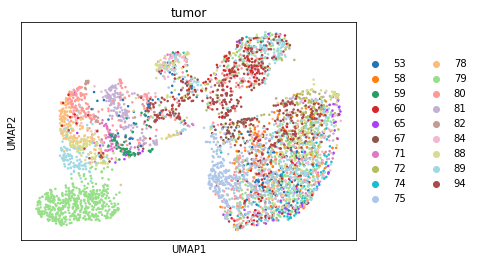

In [106]:
sc.pl.umap(adata_h, color=["tumor"])

In [107]:
# Subset only the malignant cells to group these into tumor subtypes
adata_h_m = adata_h[adata_h.obs["annotated"] == "Malignant"].copy()
adata_h_m.obs_names_make_unique()
adata_h_m.var_names_make_unique()

# Find MITF and AXL related cells

In [108]:
#Read in genes associated with MITF and AXL cell types
MITF_genes = pd.read_csv("data/MITF_genes.csv", skiprows=3, header=None, dtype=str) #Sup table 7
MITF_genes = [gene[0] for gene in MITF_genes.values]
AXL_genes = pd.read_csv("data/AXL_genes.csv", skiprows=3, header=None, dtype=str) # Sup table 8
AXL_genes = [gene[0] for gene in AXL_genes.values]

# Store gene set score for each cell
sc.tl.score_genes(adata_h_m, gene_list=list(MITF_genes), ctrl_size=200, score_name="MITF_score")
sc.tl.score_genes(adata_h_m, gene_list=list(AXL_genes), ctrl_size=200, score_name="AXL_score")

# Assign either MITF or AXL for each cell
adata_h_m.obs["MITF/AXL"] = ["MITF" if score[1]["MITF_score"] > score[1]["AXL_score"] else "AXL" for score in adata_h_m.obs[["MITF_score","AXL_score"]].iterrows()]


... storing 'MITF/AXL' as categorical


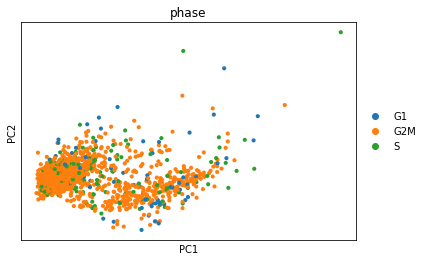

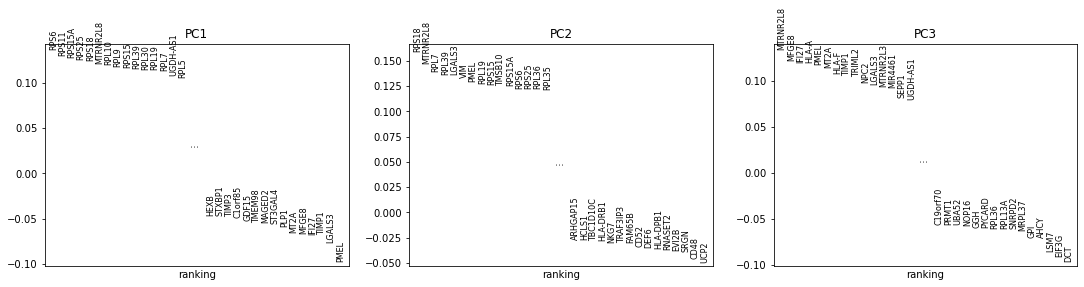

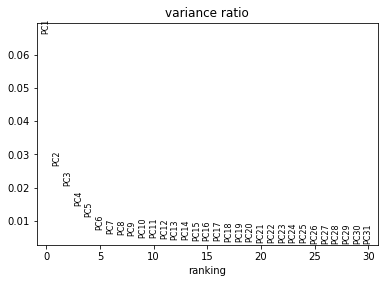

In [109]:
sc.pp.pca(adata_h_m)
sc.pl.pca_overview(adata_h_m, color="phase")

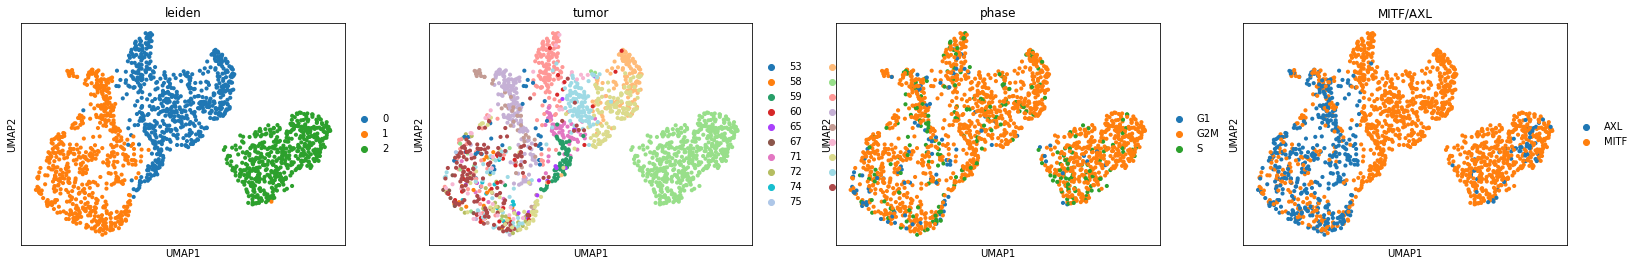

In [110]:
sc.pp.neighbors(adata_h_m, n_pcs=4, n_neighbors=25)

#sce.pp.bbknn(adata_h_m, n_pcs=6, batch_key="phase")
sc.tl.diffmap(adata_h_m, n_comps=6)
sc.tl.leiden(adata_h_m, resolution=0.1)
sc.tl.umap(adata_h_m)
sc.pl.umap(adata_h_m, color=["leiden", "tumor", "phase", "MITF/AXL"])

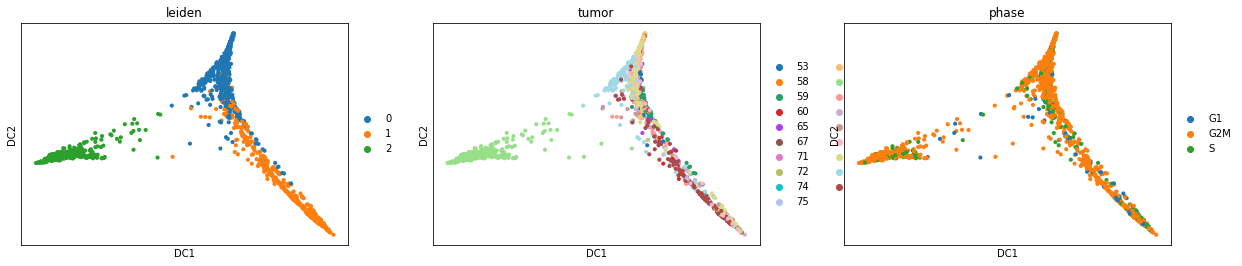

In [111]:
sc.pl.diffmap(adata_h_m, color=["leiden", "tumor", "phase"])


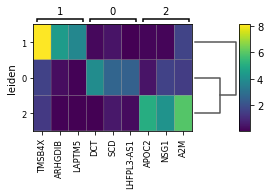

In [112]:
sc.tl.rank_genes_groups(adata_h_m, groupby="leiden")
sc.pl.rank_genes_groups_matrixplot(adata_h_m, n_genes=3, groupby="leiden")

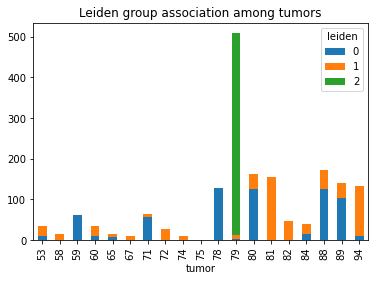

In [113]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status"]]
df = df.pivot_table(index="tumor", columns="leiden", aggfunc="count", values="resection")
df.plot(kind="bar", stacked=True, title="Leiden group association among tumors")

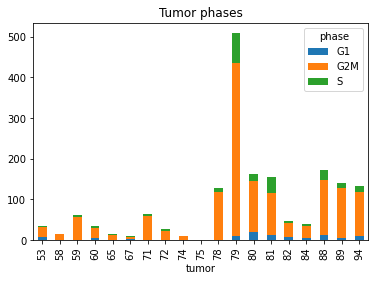

In [114]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status","phase"]]
df = df.pivot_table(index="tumor", columns="phase", aggfunc="count", values="resection")
df.plot(kind="bar", stacked=True, title="Tumor phases")

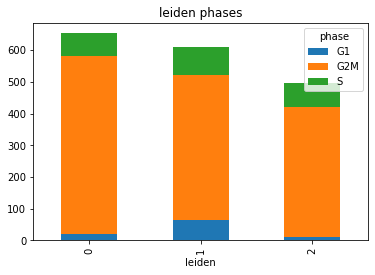

In [115]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status","phase"]]
df = df.pivot_table(index="leiden", columns="phase", aggfunc="count", values="resection")
df.plot(kind="bar", stacked=True, title="leiden phases")

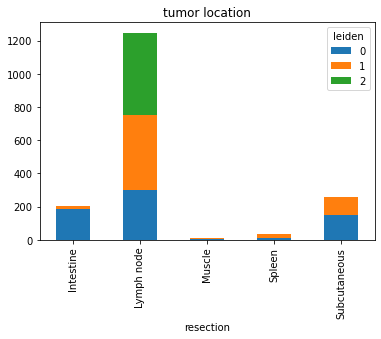

In [116]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status"]]
df = df.pivot_table(index="resection", columns="leiden", aggfunc="count", values="tumor")
df.plot(kind="bar", stacked=True, title="tumor location")

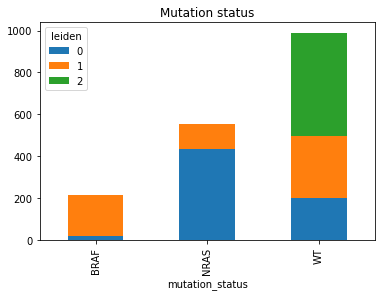

In [117]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status"]]
df = df.pivot_table(index="mutation_status", columns="leiden", aggfunc="count", values="tumor")
df.plot(kind="bar", stacked=True, title="Mutation status")

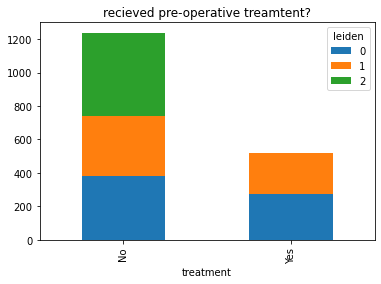

In [118]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status", "treatment"]]
df = df.pivot_table(index="treatment", columns="leiden", aggfunc="count", values="tumor")
df.plot(kind="bar", stacked=True, title="recieved pre-operative treamtent?")

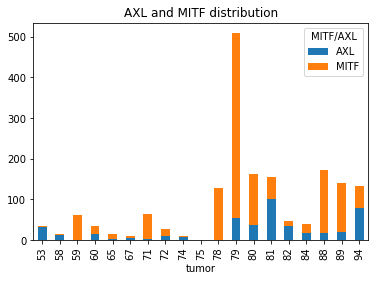

In [171]:
df = adata_h_m.obs[["leiden", "tumor","resection", "mutation_status", "MITF/AXL"]]
df = df.pivot_table(index="tumor", columns="MITF/AXL", aggfunc="count", values="leiden")
import matplotlib.pyplot as plt
df.plot(kind="bar", stacked=True, title="AXL and MITF distribution")
plt.savefig("figures/AXL-MITF-distribution.pdf")

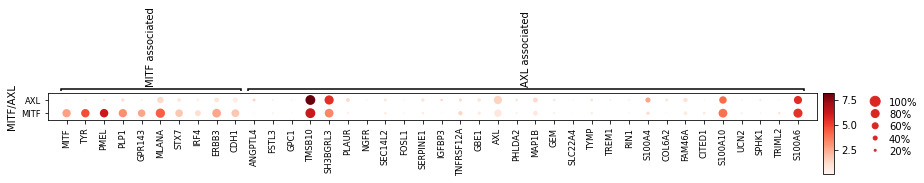

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[14.0, 0, 0.2, 0.5, 0.25])

In [120]:
# Annotations based on original athors
torish_genes = {
    "MITF associated": MITF_genes[0:10],
    "AXL associated": AXL_genes[0:30]

}
sc.pl.dotplot(adata_h_m, var_names=torish_genes, groupby="MITF/AXL")

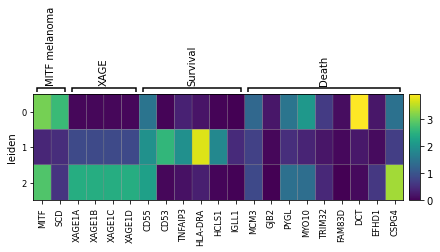

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[6.72, 0, 0.2])

In [121]:
tumor_genes = {
    "MITF melanoma": ["MITF", "SCD"], #https://www.sciencedirect.com/science/article/pii/S1097276519307920?casa_token=2Q2jcqvo_wwAAAAA:f3v76o1nJC35SwOjGQT_9Avc3fY2Imp8FOoCkEZ_qUSKeB-h21KL3LOJCnZxmG1cUdqY5dj9LvA
    "XAGE": ["XAGE1A","XAGE1B","XAGE1C", "XAGE1D"], #https://onlinelibrary.wiley.com/doi/full/10.1002/ijc.10371
    "Survival": ["CD55", "CD53", "TNFAIP3", "HLA-DRA", "HCLS1", "IGLL1"], # https://link.springer.com/article/10.1186/1479-5876-4-50
    "Death": ["MCM3", "GJB2", "PYGL", "MYO10", "TRIM32", "FAM83D", "DCT", "EFHD1", "CSPG4"] # https://link.springer.com/article/10.1186/1479-5876-4-50
    
}

sc.pl.matrixplot(adata_h_m, var_names=tumor_genes, groupby="leiden")

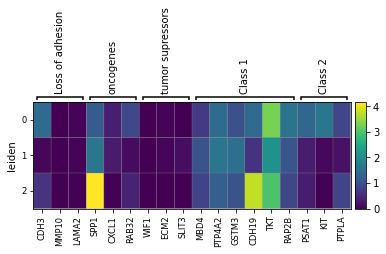

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[5.76, 0, 0.2])

In [122]:
melanoma_development = { #https://www.pnas.org/content/102/17/6092.full
    "Loss of adhesion": ["CDH3","MMP10","LAMA2"],
    "oncogenes": ["SPP1","CXCL1", "RAB32"],
    "tumor supressors": ["WIF1", "ECM2", "SLIT3"],
    "Class 1": ["MBD4", "PTP4A2", "GSTM3", "CDH19", "TKT", "RAP2B"],
    "Class 2": ["PSAT1", "KIT","PTPLA"]
    }

sc.pl.matrixplot(adata_h_m, var_names=melanoma_development, groupby="leiden")

In [123]:
# Lets add the new tumor groups to the original dataset
tumor_map = {
    "0": "Tumor type 1",
    "1": "Tumor type 2",
    "2": "Tumor type 3",
    "3": "Tumor type 4",
    "4": "Tumor type 5"
}
# use tumor_map[group] to map back the found liden groups instead
adata_h_m.obs["annotated"] = [group for group in adata_h_m.obs["MITF/AXL"]]

# edit annotations in place (anno_h is the annotation vector and will link back to original dataset)
anno_h = adata_h.obs["annotated"]
anno_h_m = pd.Series(adata_h_m.obs["annotated"])

In [124]:
# add tumor_map.values() if leiden groups is needed
anno_h.cat.add_categories(["MITF", "AXL"], inplace=True)
anno_h.cat.remove_categories("Malignant", inplace=True)

for i, group in anno_h_m.items():
    anno_h.loc[i] = group

    
adata_h.var_names_make_unique()
adata_h.obs_names_make_unique()

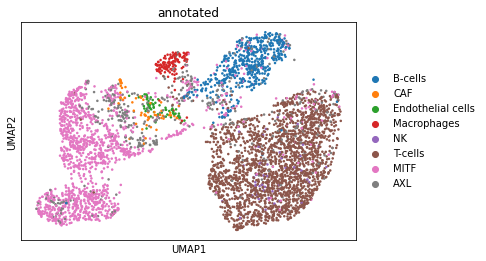

In [125]:

sc.pl.umap(adata_h, color=["annotated"])

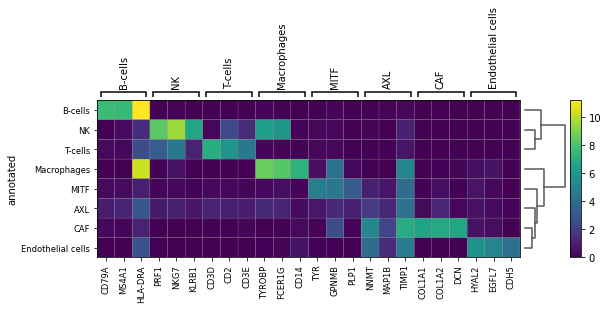

In [126]:
# Lets find new DE genes when we can compare to host cells
sc.tl.dendrogram(adata_h, groupby="annotated")
sc.tl.rank_genes_groups(adata_h, groupby="annotated", penalty='l1')
sc.pl.rank_genes_groups_matrixplot(adata_h, groupby="annotated", n_genes=3)

In [127]:
tumor_map = {
    "Tumor type 1": "Tumor Dopachrome Tautomerase",
    "Tumor type 2": "Tumor p21 (NSG1)",
    "Tumor type 3": "Tumor Remission",
    "Tumor type 4": "Tumor Transferin"
}

adata_h.obs["annotated_2"] = [tumor_map[group] if group in tumor_map.keys() else group for group in adata_h.obs["annotated"]]


... storing 'annotated_2' as categorical


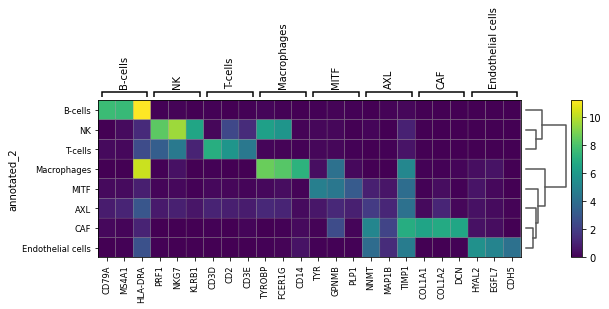

In [128]:
# Lets find new DE genes when we can compare to host cells
#sc.tl.dendrogram(adata_h, groupby="annotated_2")
sc.tl.rank_genes_groups(adata_h, groupby="annotated_2")
sc.pl.rank_genes_groups_matrixplot(adata_h, groupby="annotated_2", n_genes=3)

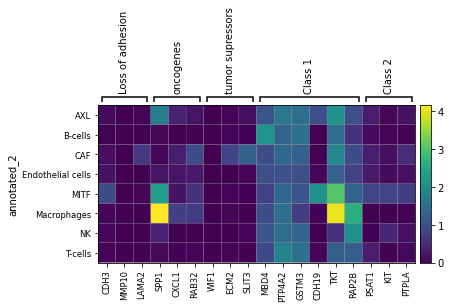

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[5.76, 0, 0.2])

In [129]:
sc.pl.matrixplot(adata_h, var_names=melanoma_development, groupby="annotated_2")

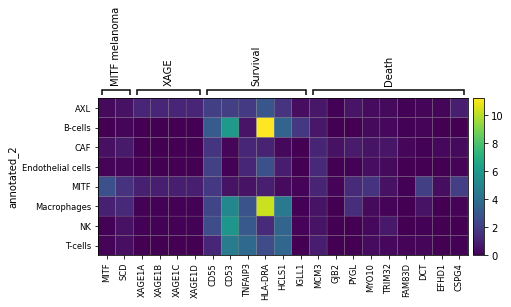

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[6.72, 0, 0.2])

In [130]:
sc.pl.matrixplot(adata_h, var_names=tumor_genes, groupby="annotated_2")

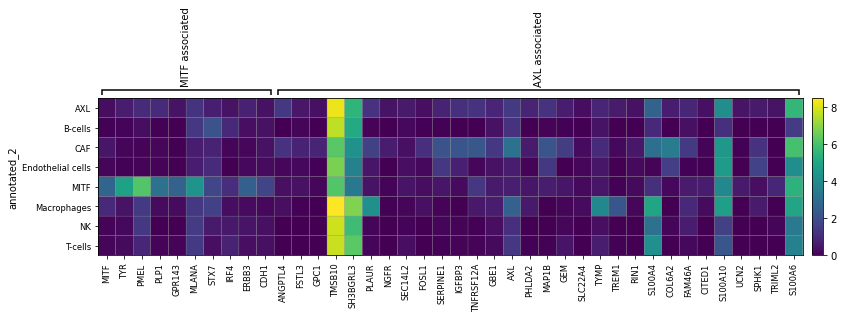

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[12.8, 0, 0.2])

In [131]:
sc.pl.matrixplot(adata_h, var_names=torish_genes, groupby="annotated_2")

# Connectivity analysis

In [87]:
# ONLY RUN ONCE
# make a hsapiens database with "gpcr", "lgic", "catalytic_receptor", "nhr" receptor types
#cn.database.setup_database(organism="hsapiens", receptor_types=["gpcr", "lgic", "catalytic_receptor", "nhr"])
#cn.database.get_peptide_ligands(organism="hsapiens")

fetching GTF version 2019-5


C:\Users\jonja158\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DtypeWarning:

Columns (5,7,8,9,34) have mixed types.Specify dtype option on import or set low_memory=False.



getting peptide ligands...


C:\Users\jonja158\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DtypeWarning:

Columns (6,8,9,10,35) have mixed types.Specify dtype option on import or set low_memory=False.



found 401 peptide ligands
getting molecule ligands...
found 8 molecular ligands
merging ligands...
getting receptors...
found 681 receptors
getting interactions...
Database build complete


C:\Users\jonja158\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DtypeWarning:

Columns (6,8,9,10,35) have mixed types.Specify dtype option on import or set low_memory=False.



In [159]:
from numpy import exp2

adata_h = cn.genecall.meanExpression(adata_h, groupby="annotated", transformation=lambda x:(exp2(x)-1), normalization=False, use_raw=True)
#Provide data in TPM (linear scale of counts)


using provided function


In [160]:
adata_h = cn.connect.ligands(adata_h, organism="hsapiens")
adata_h = cn.connect.receptors(adata_h, organism="hsapiens")

C:\Users\jonja158\Anaconda3\lib\site-packages\scipy\stats\stats.py:330: RuntimeWarning:

divide by zero encountered in log



In [161]:
edges = cn.connect.interactions(adata_h, adata_h, self_reference=True, organism="hsapiens")
nodes = cn.connect.nodes(adata_h)

finding connections between 8 emitter clusters and 8 target clusters |██████████████████████████████| 100.0% 
precessing adata #1
processing cluster B-cells
processing cluster CAF
processing cluster Endothelial cells
processing cluster Macrophages
processing cluster NK
processing cluster T-cells
processing cluster MITF
processing cluster AXL


In [162]:
G = cn.graph.build_graph(edges, nodes)

Graph has 17545 interactions between 8 clusters
B-cells has 4962 interactions
CAF has 3614 interactions
Endothelial cells has 3020 interactions
Macrophages has 3823 interactions
NK has 2487 interactions
T-cells has 5928 interactions
MITF has 5778 interactions
AXL has 5478 interactions


In [166]:
from importlib import reload
cn.genecall = reload(cn.genecall)
cn.connect = reload(cn.connect)
cn.graph = reload(cn.graph)
cn.app = reload(cn.app)
cn.app.graph(G)

please open: http://127.0.0.1:8050/
 * Serving Flask app "connectome.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [05/Jun/2020 15:22:36] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:39] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:22:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:24:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 15:24:12] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [05/Jun/2020 

In [163]:
Gs = cn.graph.split_graph(G)

In [164]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(interaction):
    return cn.graph.plot_adjacency_matrix(Gs[interaction], weight="score")

options = list(Gs.keys())
options.sort()
interact(f, interaction=widgets.Dropdown(options=options, index=0))

interactive(children=(Dropdown(description='interaction', options=('(-)-adrenaline --> α1A-adrenoceptor', '(-)…

<function __main__.f(interaction)>

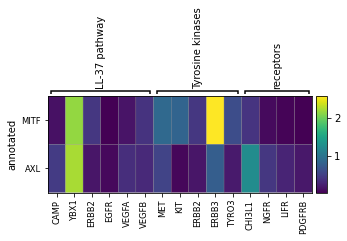

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[4.8, 0, 0.2])

In [139]:
relevant_genes= {
    "LL-37 pathway": ["CAMP", "YBX1", "ERBB2", "EGFR","VEGFA","VEGFB"],
    "Tyrosine kinases": ["MET", "KIT", "ERBB2", "ERBB3","TYRO3"],
    "receptors": ["CHI3L1", "NGFR", "LIFR", "PDGFRB"]
}

selection = [True if cell_type in ["AXL", "MITF"] else False for cell_type in adata_h.obs["annotated"]]
sc.pl.matrixplot(adata_h[selection], groupby="annotated", var_names=relevant_genes, use_raw=True)

#  Differences in Interaction score

In [80]:
#Old version of annotating differences, see further down for new version
import networkx as nx

sources = ["B-cells","CAF","Endothelial cells","Macrophages","NK","T-cells", "AXL", "MITF"]

compare = ["MITF", "AXL"]
MITF_i_dict = dict()
for source in sources:
    diff_dict = dict()
    for interaction in Gs:
        df = nx.to_pandas_adjacency(Gs[interaction], weight="log_score")
        a = df[compare[0]][source]
        b = df[compare[1]][source]
        #diff = (a/(a+b))*(a-b)
        diff = a-b
        diff_dict[interaction] = {"Source": source, compare[0]: a, compare[1]: b, "diff": diff}
    MITF_i_dict[source] = diff_dict

compare = ["AXL","MITF"]
AXL_i_dict = dict()
for source in sources:
    diff_dict = dict()
    for interaction in Gs:
        df = nx.to_pandas_adjacency(Gs[interaction], weight="log_score")
        a = df[compare[0]][source]
        b = df[compare[1]][source]
        #diff = (a/(a+b))*(a-b)
        diff = a-b
        diff_dict[interaction] = {"Source": source, compare[0]: a, compare[1]: b, "diff": diff}
    AXL_i_dict[source] = diff_dict
    

compare = ["MITF", "AXL"]
MITF_o_dict = dict()
for source in sources:
    diff_dict = dict()
    for interaction in Gs:
        df = nx.to_pandas_adjacency(Gs[interaction], weight="log_score")
        a = df[source][compare[0]]
        b = df[source][compare[1]]
        #diff = (a/(a+b))*(a-b)
        diff = a-b
        diff_dict[interaction] = {"Source": source, compare[0]: a, compare[1]: b, "diff": diff}
    MITF_o_dict[source] = diff_dict

compare = ["AXL","MITF"]
AXL_o_dict = dict()
for source in sources:
    diff_dict = dict()
    for interaction in Gs:
        df = nx.to_pandas_adjacency(Gs[interaction], weight="log_score")
        a = df[source][compare[0]]
        b = df[source][compare[1]]
        #diff = (a/(a+b))*(a-b)
        diff = a-b
        diff_dict[interaction] = {"Source": source, compare[0]: a, compare[1]: b, "diff": diff}
    AXL_o_dict[source] = diff_dict

In [81]:
pd.DataFrame(AXL_o_dict["Endothelial cells"]).T.sort_values(by="diff", ascending=False).head(10)

,Source,AXL,MITF,diff
lymphotoxin-α --> tumor necrosis factor receptor 1,Endothelial cells,0.639053,0.36176,0.277293
lymphotoxin-α --> herpes virus entry mediator,Endothelial cells,0.63623,0.35969,0.276539
(-)-adrenaline --> α1A-adrenoceptor,Endothelial cells,0.270925,0,0.270925
chemerin --> chemerin receptor 2,Endothelial cells,0.611167,0.351537,0.25963
lymphotoxin-α --> tumor necrosis factor receptor 2,Endothelial cells,0.532369,0.286142,0.246227
tumour necrosis factor membrane form --> tumor necrosis factor receptor 1,Endothelial cells,0.791326,0.562026,0.2293
tumour necrosis factor shed form --> tumor necrosis factor receptor 1,Endothelial cells,0.791326,0.562026,0.2293
CD40 ligand --> CD40,Endothelial cells,0.578206,0.361932,0.216274
oncostatin M --> Leukemia inhibitory factor receptor,Endothelial cells,0.476287,0.260156,0.21613
B and T lymphocyte attenuator --> herpes virus entry mediator,Endothelial cells,0.812255,0.599085,0.21317


In [82]:
pd.DataFrame(MITF_o_dict["MITF"]).T.sort_values(by="diff", ascending=False).head(10)

,Source,MITF,AXL,diff
growth differentiation factor 15 --> GDNF family receptor alpha like,MITF,0.683722,0.522174,0.161549
acetylcholine --> M3 receptor,MITF,0.161059,0,0.161059
protein S --> AXL receptor tyrosine kinase,MITF,0.832732,0.683922,0.14881
protein S --> TYRO3 protein tyrosine kinase,MITF,0.795869,0.64976,0.14611
OX-40 ligand --> OX40,MITF,0.387332,0.24764,0.139692
GABA --> GABAB1,MITF,0.130439,0,0.130439
SRIF-14 --> SST2 receptor,MITF,0.0916299,0,0.0916299
SRIF-28 --> SST2 receptor,MITF,0.0916299,0,0.0916299
RFRP-3 --> NPFF2 receptor,MITF,0.0818994,0,0.0818994
neuregulin-3 --> erb-b2 receptor tyrosine kinase 4,MITF,0.11324,0.0335234,0.0797165


In [83]:
pd.DataFrame(AXL_i_dict["NK"]).T.sort_values(by="diff", ascending=False).head(10)

,Source,AXL,MITF,diff
CCL22 --> CCR4,NK,0.575145,0.235749,0.339396
annexin I --> FPR1,NK,0.76635,0.428967,0.337383
annexin I-(2-26) --> FPR1,NK,0.76635,0.428967,0.337383
CCL5 --> CCR5,NK,0.856645,0.589896,0.266749
CCL4 --> CCR5,NK,0.8356,0.571796,0.263804
CCL3 --> CCR5,NK,0.748944,0.498632,0.250311
annexin I --> FPR2/ALX,NK,0.62059,0.385284,0.235306
annexin I-(2-26) --> FPR3,NK,0.62059,0.385284,0.235306
annexin I-(2-26) --> FPR2/ALX,NK,0.62059,0.385284,0.235306
"IL-10 --> Interleukin 10 receptor, α subunit",NK,0.833056,0.607936,0.22512


In [84]:
pd.DataFrame(MITF_i_dict["NK"]).T.sort_values(by="diff", ascending=False).head(10)

,Source,MITF,AXL,diff
xenin --> NTS2 receptor,NK,0.168337,0,0.168337
LIGHT --> herpes virus entry mediator,NK,1.04307,0.924723,0.118345
CCL28 --> CCR10,NK,0.569545,0.458881,0.110663
lymphotoxin-α --> herpes virus entry mediator,NK,0.811656,0.702742,0.108914
B and T lymphocyte attenuator --> herpes virus entry mediator,NK,0.570464,0.478005,0.0924594
α-MSH --> MC4 receptor,NK,0.185986,0.100671,0.0853148
ACTH --> MC4 receptor,NK,0.185986,0.100671,0.0853148
macrophage stimulating protein 1 --> macrophage stimulating 1 receptor,NK,0.206784,0.130296,0.0764882
LIGHT --> lymphotoxin β receptor,NK,0.991616,0.921519,0.0700969
Wnt-4 --> FZD6,NK,0.283546,0.213704,0.0698416


incomming interactions
Outgoing interactions
receptor families in order: ['Chemokine receptors', 'Chemerin receptors', 'Class A Orphans', 'Prolactin receptor family', 'Formylpeptide receptors', 'Leukotriene receptors', 'Type II receptor serine/threonine kinases']


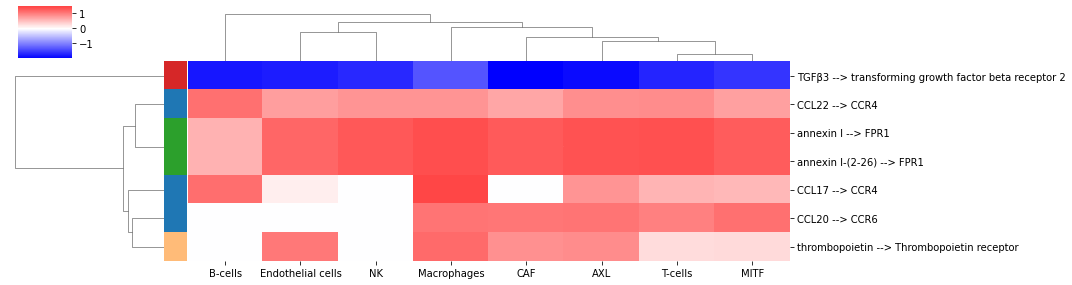

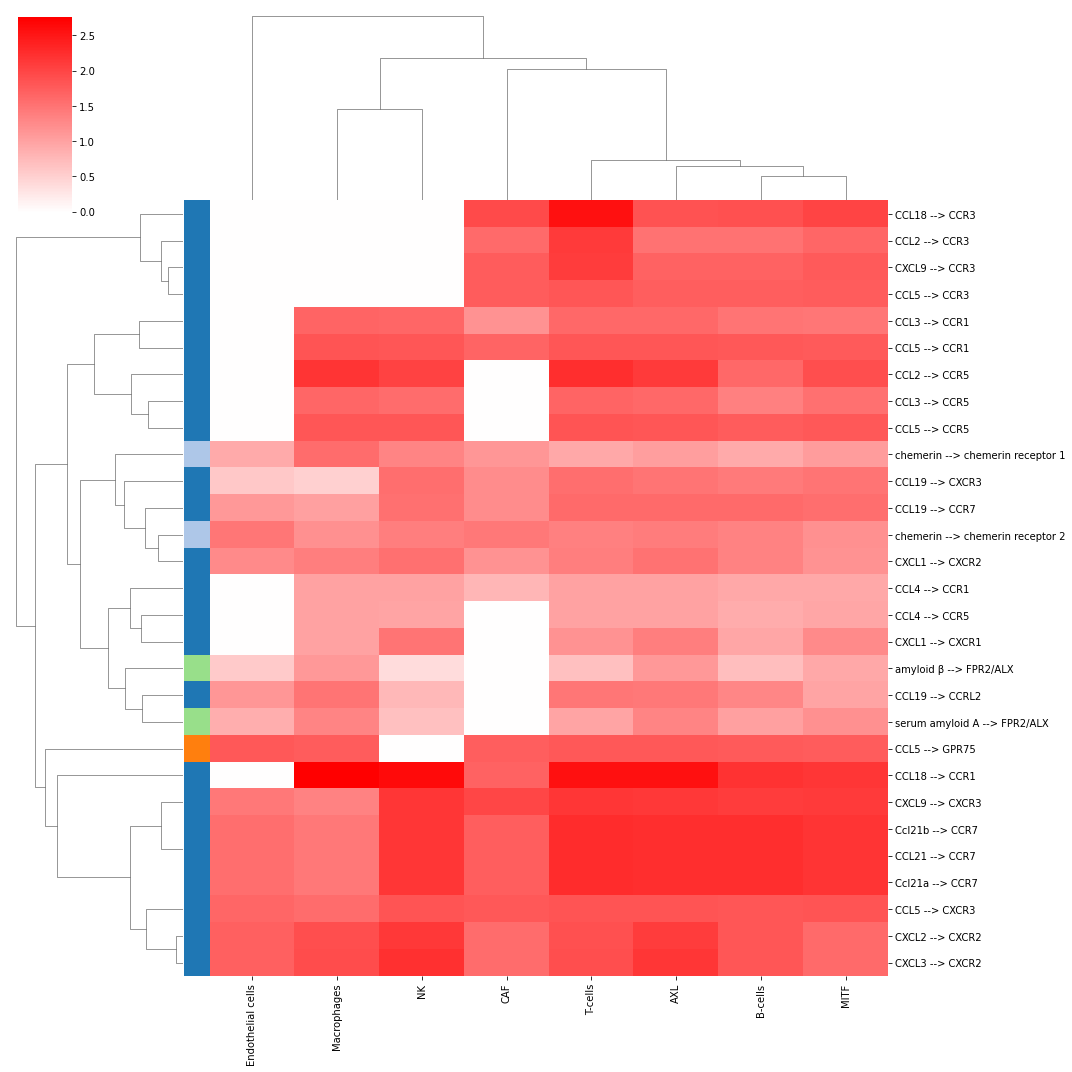

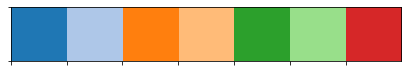

In [193]:
cn.graph.compare_interactions_plot(G, node_a="AXL", node_b="MITF", th=10, colormap="tab20", figsize_i=(15,4), figsize_o=(15,15), save="figures/")
